In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The Data

In [2]:
rainfall_df = pd.read_csv('data/historical_rainfall_ca.csv')
avocado_df = pd.read_csv('data/historical_avocado_ca.csv')
avocado_df['Crop Value ($)'] = avocado_df['Crop Value ($)'].str.replace('$', '').str.replace(',', '').apply(int)

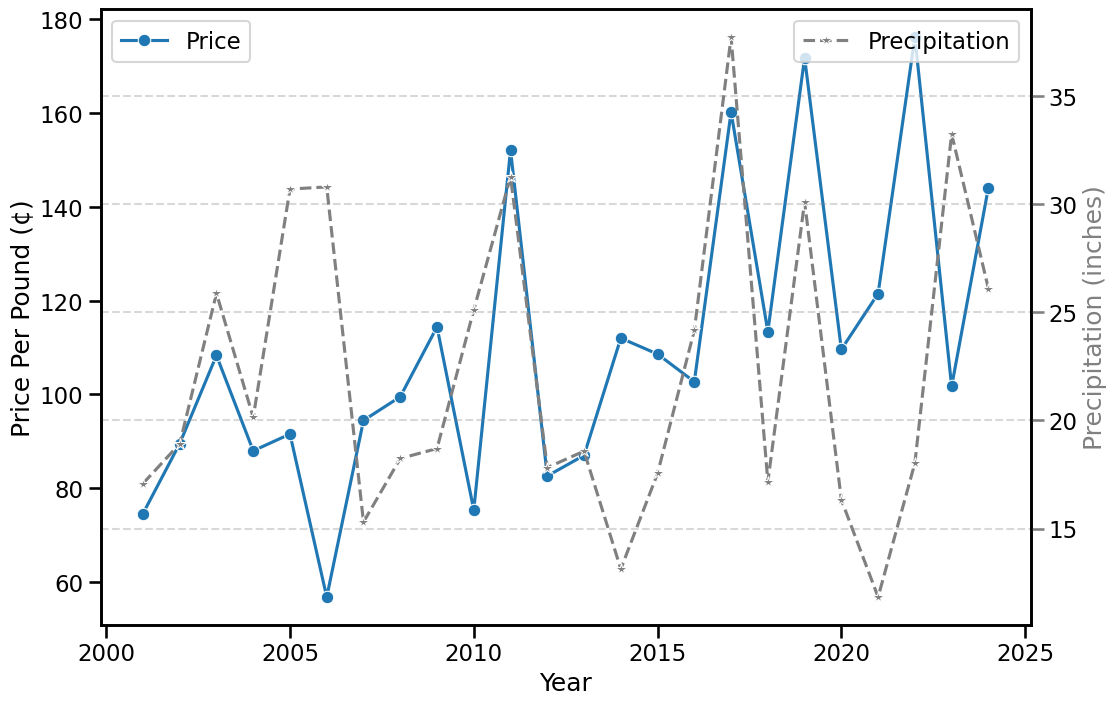

In [3]:
with sns.plotting_context('talk', font_scale=1):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(
        data=avocado_df, x='Year', y='Price Per Pound (¢)', ax=ax, marker='o', label='Price'
    )
    ax2 = ax.twinx()
    sns.lineplot(
        data=rainfall_df.query('Year >= @avocado_df["Year"].min()'),
        x='Year', y='Precipitation (inches)', ax=ax2, marker='*', color='gray', linestyle='--', label='Precipitation'
    )    
    ax2.grid(visible=True, linestyle='--', color='gray', alpha=0.3)
    ax2.set_ylabel('Precipitation (inches)', color='gray')
    ax2.tick_params(axis='y', color='gray')
    plt.show()

We can see the price per pound fluctuate, yet increase over time. Rainfall seems to have a relationship with the price, although it is more likely to impact years down the line (since avocados can take years to grow).

Will consider a max lag of 4 years.

In [4]:
def create_merged_df(av_df, rn_df, lag):
    return av_df[['Year', 'Price Per Pound (¢)']].merge(
        rn_df[['Year']].assign(precip=rainfall_df['Precipitation (inches)'].shift(lag)),
        on='Year', how='inner'
    )

In [5]:
shft_corr_list = []
for shft in range(5):
    corr = create_merged_df(avocado_df, rainfall_df, shft).drop(columns='Year').corr().iloc[1, 0]
    shft_corr_list.append((shft, corr))
shft_corr_df = pd.DataFrame(shft_corr_list)
shft_corr_df.columns = ['lag', 'corr']

In [6]:
shft_corr_df

,lag,corr
0,0,0.232694
1,1,-0.169857
2,2,-0.002836
3,3,-0.129274
4,4,-0.316887


We see a relatively negative correlation with a lag of 4, i.e. rainfall has, potentially, the most impact after 4 years. We can plot to see the comparisons.

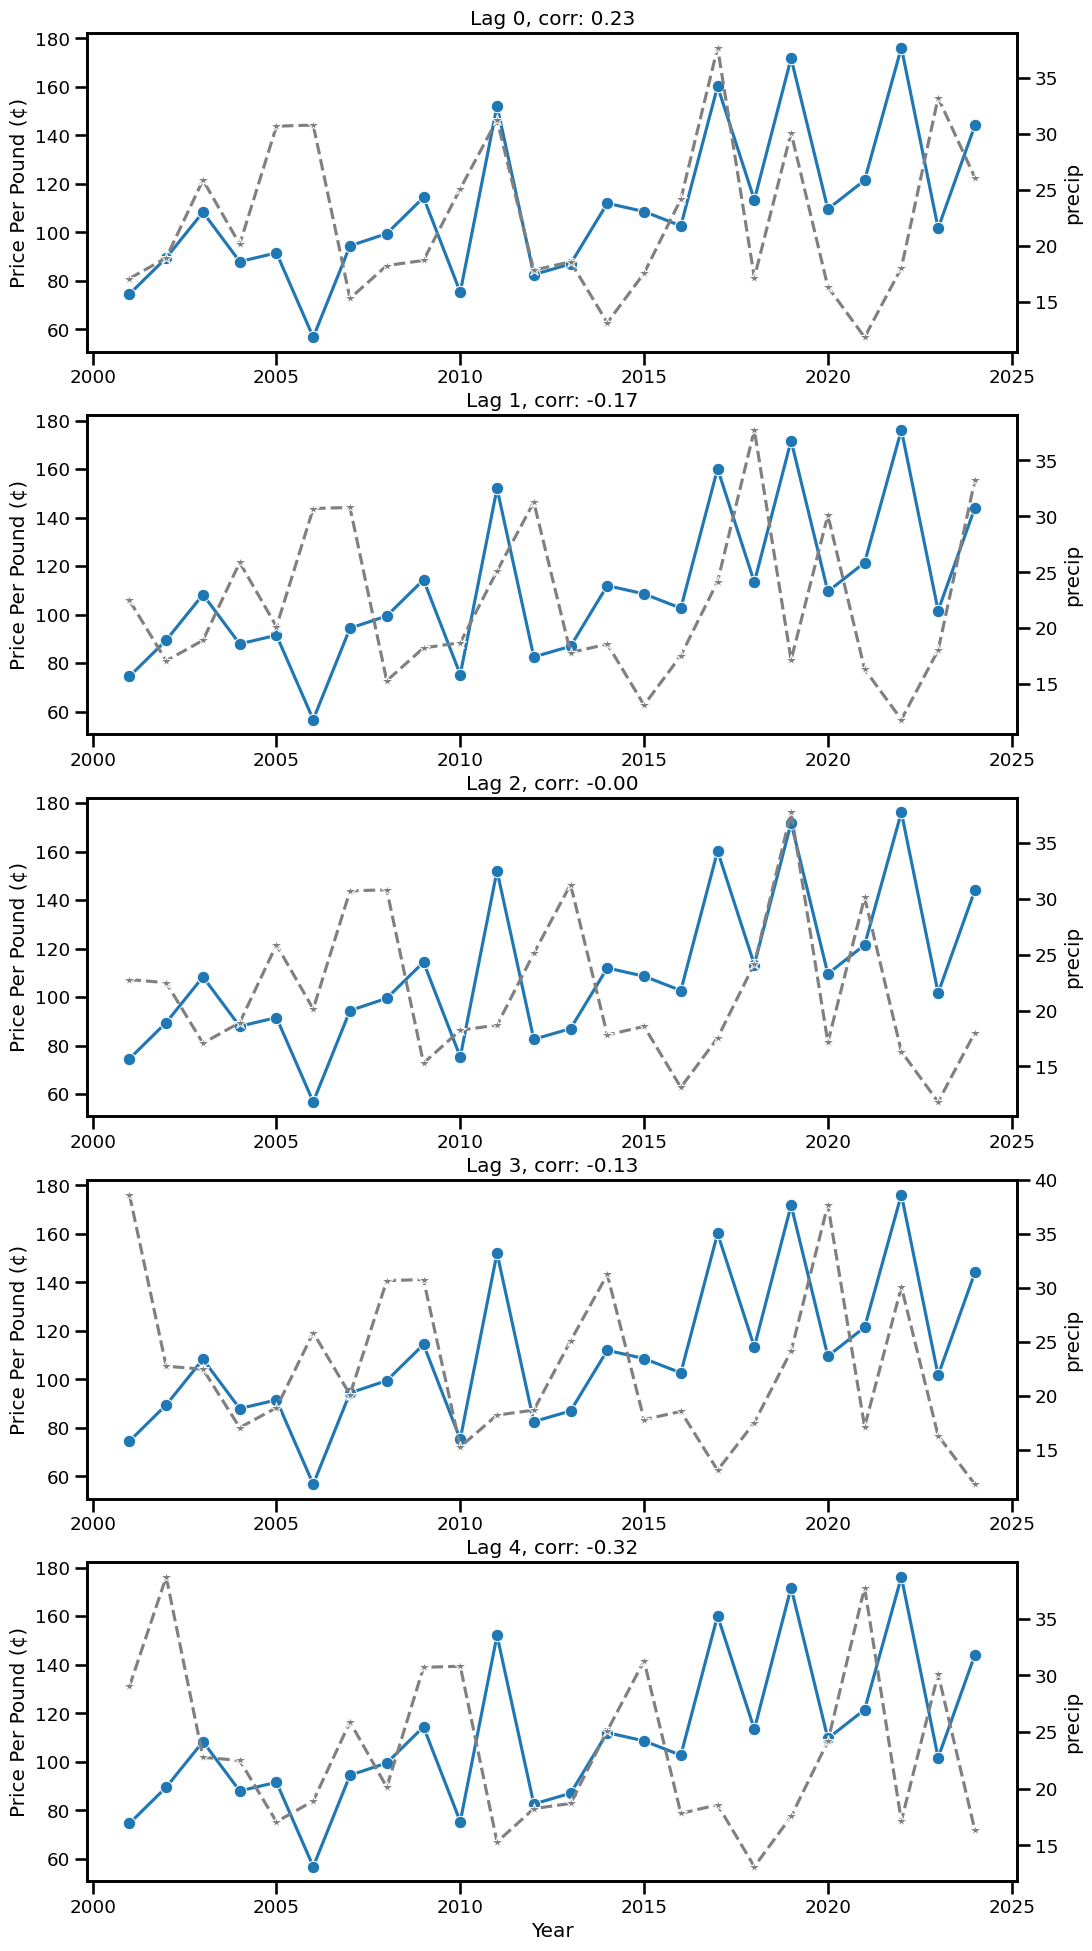

In [7]:
with sns.plotting_context('talk', font_scale=0.8):
    fig, ax = plt.subplots(5, 1, figsize=(12, 24))
    for i, ax_ in enumerate(ax):
        sns.lineplot(
            data=avocado_df, x='Year', y='Price Per Pound (¢)', ax=ax_, marker='o'
        )
        ax2 = ax_.twinx()
        merged_df = create_merged_df(avocado_df, rainfall_df, i)
        sns.lineplot(
            data=merged_df, x='Year', y='precip', ax=ax2, marker='*', color='grey', linestyle='--'
        )
        ax_.set_title('Lag ' + str(i) + ', corr: ' + '{:.2f}'.format(shft_corr_df['corr'].iloc[i]))
        ax_.set_xlabel('')
    ax_.set_xlabel('Year')
    plt.show()

Lag 4 does seem to have the most correlation since there are more instances of the price being low when the precipitation is high and vice-vera.

# Forecasting

We will use a test period of four years since the lag we saw have the most correlation was also four.

In [8]:
merged_df = create_merged_df(avocado_df, rainfall_df, 4)
df = merged_df[['Year', 'Price Per Pound (¢)', 'precip']].rename(
    columns={'Year': 'ds', 'Price Per Pound (¢)': 'y', 'precip': 'reg'}
)
df['ds'] = pd.to_datetime(df['ds'], format='%Y')
df_train = df.query('ds.dt.year < 2021').copy()
df_test = df.query('ds.dt.year >= 2021').copy()

In [9]:
from prophet import Prophet

/opt/anaconda3/envs/yf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
m = Prophet()
m.fit(df_train[['ds', 'y']])

16:02:43 - cmdstanpy - INFO - Chain [1] start processing
16:02:43 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
def get_train_test_err_df(train_df, test_df, proph_model):
    total_err_df = pd.DataFrame()
    for err_df, fcast_type in zip([train_df, test_df], ['train', 'test']):
        temp_err_df = err_df[['ds', 'y', 'reg']].reset_index(drop=True)
        temp_err_df['yhat'] = proph_model.predict(err_df[['ds', 'reg']])['yhat']
        temp_err_df['abs_error'] = (temp_err_df['y'] - temp_err_df['yhat']).abs()
        temp_err_df['abs_perc_error'] = temp_err_df['abs_error']/temp_err_df['y']
        temp_err_df['forecast_type'] = fcast_type
        total_err_df = pd.concat([total_err_df, temp_err_df], ignore_index=True)
    return total_err_df

In [12]:
train_test_err_df = get_train_test_err_df(df_train, df_test, m)

In [13]:
train_test_err_df.groupby('forecast_type')[['abs_error', 'abs_perc_error']].describe().T

forecast_type              test      train
abs_error      count   4.000000  20.000000
               mean   23.710911  18.160921
               std    17.114438  14.311591
               min     3.232034   0.380219
               25%    12.796262   5.092419
               50%    26.417594  14.656068
               75%    37.332243  27.759306
               max    38.776421  46.428559
abs_perc_error count   4.000000  20.000000
               mean    0.186103   0.178796
               std     0.150986   0.155626
               min     0.022429   0.004026
               25%     0.104276   0.063866
               50%     0.170350   0.136117
               75%     0.252177   0.258406
               max     0.381282   0.636888

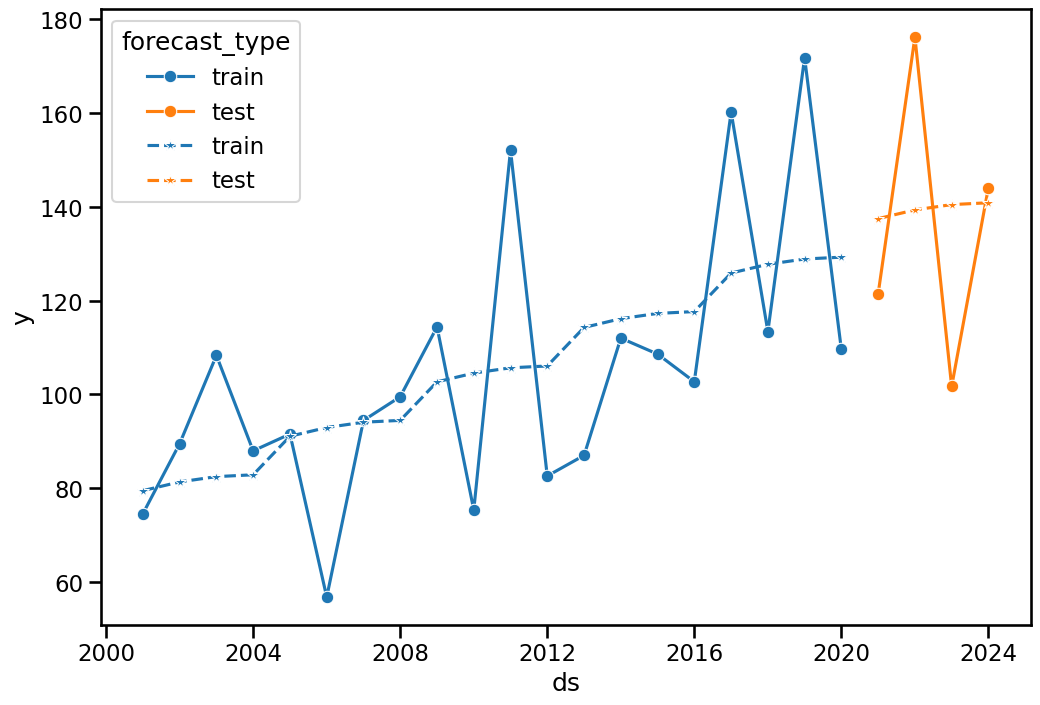

In [14]:
with sns.plotting_context('talk', font_scale=1):
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=train_test_err_df, x='ds', y='y', marker='o', hue='forecast_type'
    )
    sns.lineplot(
        data=train_test_err_df, x='ds', y='yhat',  hue='forecast_type', marker='*', color='grey', linestyle='--'
    )
    plt.show()

The average absolute percent error is 18.6% on the test set. Looking at the plot of the forecast for both periods, it seems like the model is dominated by a steadily increasing trend. The model seems to struggle to capture some of the fluctuations. The changepoint_prior_scale parameter can be tuned to allow for a less rigid model, however there is a risk of overfitting. Let us see how things change once we incorporate the influence of the rainfall data.

# Forecasting with precipitation as a regressor

In [15]:
m_reg = Prophet()
# m_reg.add_seasonality(
#     name='yearly', period=365, fourier_order=4, prior_scale=0.1
# )
m_reg.add_regressor('reg')
m_reg.fit(df_train)

16:03:18 - cmdstanpy - INFO - Chain [1] start processing
16:03:18 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
train_test_err_df_reg = get_train_test_err_df(df_train, df_test, m_reg)

In [17]:
train_test_err_df_reg.groupby('forecast_type')[['abs_error', 'abs_perc_error']].describe().T

forecast_type              test      train
abs_error      count   4.000000  20.000000
               mean   19.762181  18.071015
               std    17.090052  14.118756
               min     4.125350   1.119782
               25%     5.585107   3.850932
               50%    18.915352  15.731568
               75%    33.092425  26.290442
               max    37.092668  43.069328
abs_perc_error count   4.000000  20.000000
               mean    0.150349   0.179929
               std     0.135072   0.161872
               min     0.028628   0.011856
               25%     0.044637   0.042478
               50%     0.130244   0.150738
               75%     0.235956   0.257508
               max     0.312281   0.691811

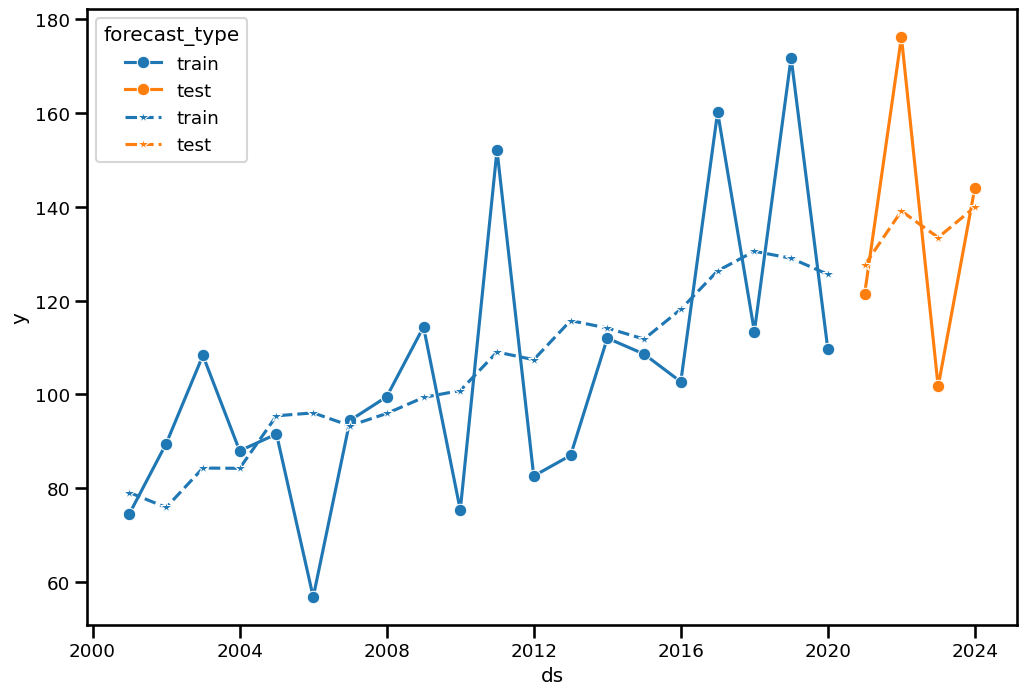

In [18]:
with sns.plotting_context('talk', font_scale=0.8):
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=train_test_err_df_reg, x='ds', y='y', marker='o', hue='forecast_type'
    )
    sns.lineplot(
        data=train_test_err_df_reg, x='ds', y='yhat',  hue='forecast_type', marker='*', color='grey', linestyle='--'
    )
    plt.show()

The train percentage error is slightly higher on average for the model with the regressor, yet the test error is significantly lower. We see that the model with the regressor is less flat, being able to mimic some of the fluctuations in the dataset for both the train and test periods.

Note: uncommenting the part with the add_seasonality method will result in an increase of accuracy. However, the purpose of this notebook is to show how regressors can improve a time series forecast.

# Future Prediction

In [19]:
future_df = pd.DataFrame()
future_df['ds'] = pd.to_datetime([2025, 2026, 2027, 2028], format='%Y')
future_df['reg'] = rainfall_df['Precipitation (inches)'].tail(4).values

m_future = Prophet()
# m_future.add_seasonality(
#     name='yearly', period=365, fourier_order=4, prior_scale=0.1
# )
m_future.add_regressor('reg')
m_future.fit(df)
forecast = m_future.predict(future_df)
future_df['y'] = forecast['yhat'].values

16:04:15 - cmdstanpy - INFO - Chain [1] start processing
16:04:15 - cmdstanpy - INFO - Chain [1] done processing


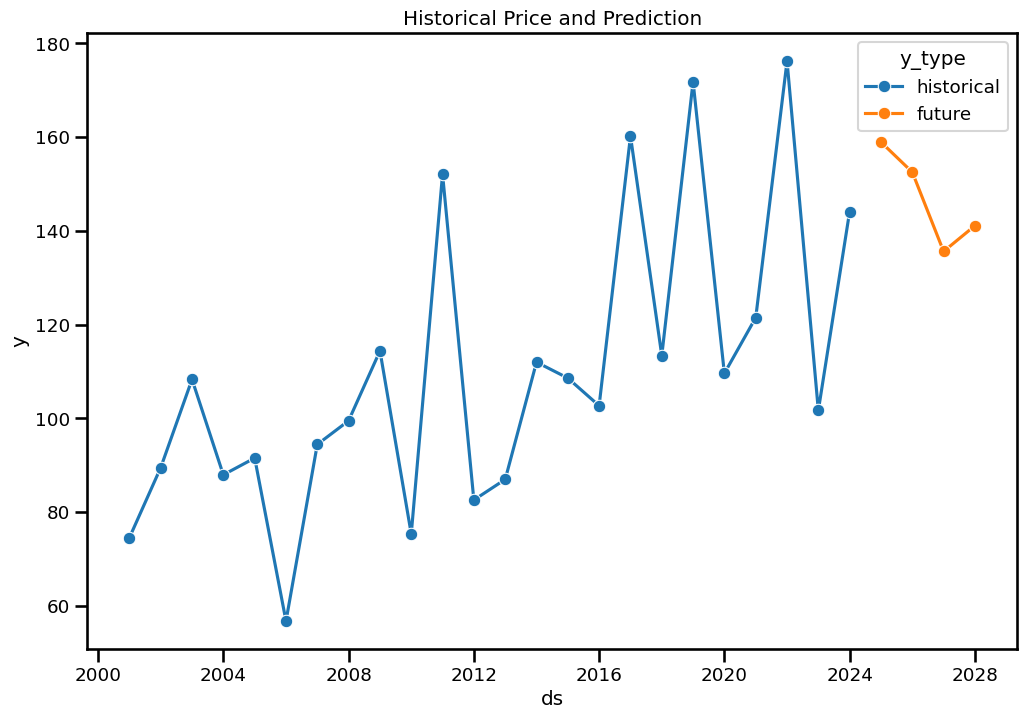

In [20]:
with sns.plotting_context('talk', font_scale=0.8):
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=pd.concat([df.assign(y_type='historical'), future_df.assign(y_type='future')], ignore_index=True),
        x='ds',
        y='y',
        marker='o', hue='y_type'
    )
    plt.title('Historical Price and Prediction')
    plt.show()